#Introduction

Neural rendering combines deep learning with classical computer graphics. Neural radiance fields (NeRF) are a popular neural rendering framework for performing 3d reconstruction from a sparse collection of input views. NeRFs provide a way to represent a photorealistic 3d scene with a low memory footprint, as only the network weights need to be stored.

# Step 1: Setup

Run this cell to install pytorch3d. This only needs to be done once. 

In [ ]:
import os
!curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
!tar xzf 1.10.0.tar.gz
os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

#for plotting results
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py


In [45]:
from typing import Optional

import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt

from torch import nn, optim

import pytorch3d

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

sys.path.append(os.path.abspath(''))
from plot_image_grid import image_grid


# Step 2: Download the data set

The first scene we will render is a lego bulldozer. In a later section of this tutorial, we will show how to use pytorch3d to generate renders of different scenes with controllable lighting and camera parameters.

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [27]:
#downloads the tiny nerf dataset
file_name = "tiny_nerf_data.npz"
url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
if not os.path.exists(file_name):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

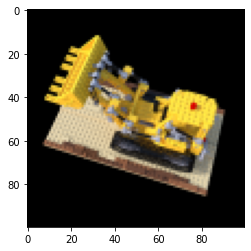

In [42]:
data = np.load("tiny_nerf_data.npz")

images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
rand_index = np.random.randint(low=0, high=num_images)
plt.imshow(images[rand_index])
plt.show()

Understanding the data format:

In [32]:
print(data.files)

['images', 'poses', 'focal']


In [43]:
poses = data["poses"]
focal_length = data["focal"]

print(np.shape(images))
print(np.shape(poses))
print(focal_length)

(106, 100, 100, 3)
(106, 4, 4)
138.88887889922103


This dataset consists of 106 renders of a lego bulldozer model with fixed lighting conditions. The parameters of the camera used to take a given image is contained in data["poses"]. The focal length of the camera is fixed for all renders

In [44]:
print(poses[rand_index])

[[-3.0372685e-01 -8.6046970e-01  4.0907466e-01  1.6490325e+00]
 [ 9.5275909e-01 -2.7430621e-01  1.3040753e-01  5.2568948e-01]
 [-7.4505793e-09  4.2935786e-01  9.0313452e-01  3.6406512e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


The pose matrix defines a coordinate transform from "world space" to "camera space". In the camera space coordinate system, the camera is positioned at the origin. The x and y axes of camera space are aligned with the image plane, while the z-axis of camera space is aligned with the viewing direction of the camera. This matrix captures both the rotation and translation that are needed to transform from world space to camera space.

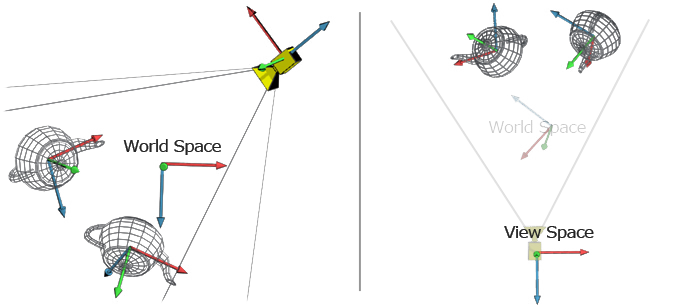

source: http://www.codinglabs.net/article_world_view_projection_matrix.aspx 

This coordinate system is convenient for computing the trajectory of viewing rays from the camera.

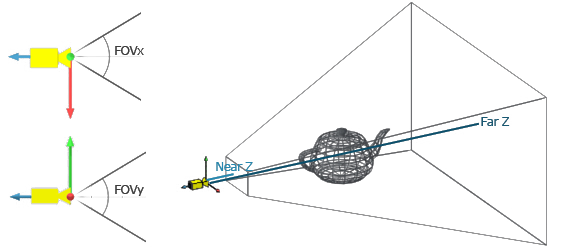

We will trace a ray originating from the camera's aperture through each pixel in the image. We will use volumetric rendering to image the output of the NeRF by accumulating sampled radiance values along each ray

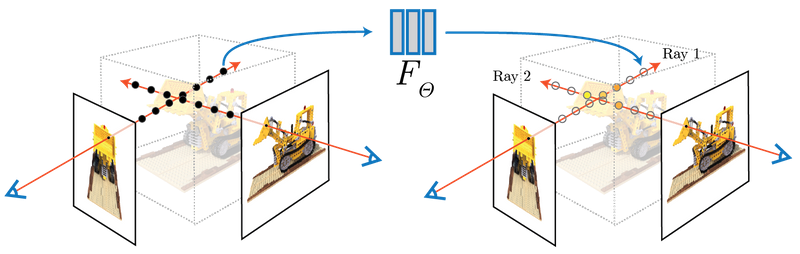

source: https://www.matthewtancik.com/nerf

# Step 3: Defining the NeRF model
In this section, we will implement a minimal NeRF architecture. This allows for fast training, but limits the precision of the reconstruction.

In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
    """
    Define a "very tiny" NeRF model comprising three fully connected layers.
    """
    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Step 4: Rendering the NeRF

Send rays from the camera's aperture through each pixel in the image. Returns a "bundle" of rays consisting of one ray per pixel (the raycaster)

In [ ]:
#see https://colab.research.google.com/drive/1rO8xo0TemN67d4mTpakrKrLp03b9bgCX?ref=morioh.com&utm_source=morioh.com#scrollTo=UuZn7lMFDZXy 
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):

Given a bundle of rays, return a collection of samples collected along each ray (the raysampler)

In [46]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):

SyntaxError: ignored

# Step 5: Training loop

In [ ]:
#forward pass
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):